Laboratory Work No.2 in the subject "Introduction to Machine Learning" by student of group DA-22, Maryna Korolova

<h4> Libraries that will be used in the work</h4> 

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
import warnings
warnings.filterwarnings("ignore")

<h4>Downloading data from csv files to pandas tables</h4>

In [2]:

train_data = pd.read_csv('data/application_train.csv')
test_data = pd.read_csv('data/application_test.csv')
id_test = test_data['SK_ID_CURR']


<h4>Initialization of the main functions, which will be used for cleaning and preparing data for processing</h4>

In [3]:
def del_column(columnToDel, data):
    data.drop(columnToDel, axis=1, inplace=True)

def combain_column(newColumnName, columnToCombain, data):
    data[newColumnName] = data[columnToCombain].sum(axis=1, skipna=True)

def clean_data(columnToDel, data):
    rowsNumber, columnsNumber = data.shape

    zero_counts = (data == 0).sum()
    nan_counts = data.isnull().sum()

    zero_percentages = (zero_counts / rowsNumber) * 100
    nan_percentages = (nan_counts / rowsNumber) * 100

    for columnName in zero_counts.index:
        if ((zero_counts[columnName] == rowsNumber) or ((zero_counts[columnName] + nan_counts[columnName]) == rowsNumber) or (nan_percentages[columnName] >= 55) or (zero_percentages[columnName] >= 90)) and (columnName != "TARGET") :
            data.drop(columnName, axis=1, inplace=True)
            columnToDel.append(columnName)

def fill_data(data):
    for columnName in data.columns:
        if data[columnName].isnull().sum() > 0:

            if data[columnName].dtype in ['float64', 'int64']:

                    mean_value = data[columnName].mean()  
                    data[columnName].fillna(mean_value, inplace=True)
            else:

                    mode_value = data[columnName].mode()[0] 
                    data[columnName].fillna(mode_value, inplace=True)

def column_to_categorical(categorical_features, data):
    for feature in categorical_features:
        data[feature] = pd.Categorical( data[feature], ordered=True) 

        
def normalized_data(data):
    numerical_features = data.select_dtypes(include=['float64', 'int64']).columns
    for column in numerical_features:
        min_val = data[column].min()
        max_val = data[column].max()
        data[column] = (data[column] - min_val) / (max_val - min_val)


def create_ordinal_features(data, ordinal_features, priority):
    for id, feature in enumerate(ordinal_features):
        replacement_dict = priority[id]
        data[feature] = data[feature].replace(replacement_dict)

def format_column_name(col_name):
    formatted = '_'.join(part.capitalize() for part in col_name.replace(' ', '_').split('_'))
    return formatted.upper()

def one_hot_encoding(data, nominal_features, categorical_features):
    categorical_features = categorical_features - set(nominal_features)
    data = pd.get_dummies(data, columns=nominal_features)
    data.columns = [format_column_name(col).upper() for col in data.columns]

    nominal_features = data.select_dtypes(include=['bool']).columns
    for feature in nominal_features:
        data[feature] = data[feature].astype(int)
        data[feature] = pd.Categorical(data[feature])

    categorical_features = categorical_features.union(set(nominal_features))
    return data,  categorical_features

def check_column(train_data, test_data):
    columns_in_train_not_in_test = set(train_data.columns) - set(test_data.columns)
    columns_in_test_not_in_train = set(test_data.columns) - set(train_data.columns)
    columns_in_both = set(train_data.columns) & set(test_data.columns)

    print(f"Сolumns in train_data, but not in test_data: {columns_in_train_not_in_test}")
    print(f"Column in test_data, but not in train_data: {columns_in_test_not_in_train}")
    print(f"Column in both DataFrames: {columns_in_both}")

    return columns_in_train_not_in_test


<h4>Display the first five rows of data for visual analysis</h4>

In [4]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.expand_frame_repr', False)
print(train_data.head())


   SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE NAME_TYPE_SUITE NAME_INCOME_TYPE            NAME_EDUCATION_TYPE    NAME_FAMILY_STATUS  NAME_HOUSING_TYPE  REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  DAYS_REGISTRATION  DAYS_ID_PUBLISH  OWN_CAR_AGE  FLAG_MOBIL  FLAG_EMP_PHONE  FLAG_WORK_PHONE  FLAG_CONT_MOBILE  FLAG_PHONE  FLAG_EMAIL OCCUPATION_TYPE  CNT_FAM_MEMBERS  REGION_RATING_CLIENT  REGION_RATING_CLIENT_W_CITY WEEKDAY_APPR_PROCESS_START  HOUR_APPR_PROCESS_START  REG_REGION_NOT_LIVE_REGION  REG_REGION_NOT_WORK_REGION  LIVE_REGION_NOT_WORK_REGION  REG_CITY_NOT_LIVE_CITY  REG_CITY_NOT_WORK_CITY  LIVE_CITY_NOT_WORK_CITY       ORGANIZATION_TYPE  EXT_SOURCE_1  EXT_SOURCE_2  EXT_SOURCE_3  APARTMENTS_AVG  BASEMENTAREA_AVG  YEARS_BEGINEXPLUATATION_AVG  YEARS_BUILD_AVG  COMMONAREA_AVG  ELEVATORS_AVG  ENTRANCES_AVG  FLOORSMAX_AVG  FLOORSMIN_AVG  LANDAREA_AVG  LIVINGAPARTMENTS_

<h4>Chose columns, which could be combain into one</h4>

In [5]:
columnToCombain = [
    'AMT_REQ_CREDIT_BUREAU_HOUR',
    'AMT_REQ_CREDIT_BUREAU_DAY',
    'AMT_REQ_CREDIT_BUREAU_WEEK',
    'AMT_REQ_CREDIT_BUREAU_MON',
    'AMT_REQ_CREDIT_BUREAU_QRT',
    'AMT_REQ_CREDIT_BUREAU_YEAR'
]

<h4>Also choose columns, which could be deleted fron the data set</h4>

In [6]:
columnToDel = [
    # Customer ID doesn't have any effect on our data
    'SK_ID_CURR',
    # We do not know what these documents mean, moreover, the data only indicate if they exist or not and most of them don`t
    'FLAG_DOCUMENT_2',
    'FLAG_DOCUMENT_3',
    'FLAG_DOCUMENT_4',
    'FLAG_DOCUMENT_5',
    'FLAG_DOCUMENT_6',
    'FLAG_DOCUMENT_7',
    'FLAG_DOCUMENT_8',
    'FLAG_DOCUMENT_9',
    'FLAG_DOCUMENT_10',
    'FLAG_DOCUMENT_11',
    'FLAG_DOCUMENT_12',
    'FLAG_DOCUMENT_13',
    'FLAG_DOCUMENT_14',
    'FLAG_DOCUMENT_15',
    'FLAG_DOCUMENT_16',
    'FLAG_DOCUMENT_17',
    'FLAG_DOCUMENT_18',
    'FLAG_DOCUMENT_19',
    'FLAG_DOCUMENT_20',
    'FLAG_DOCUMENT_21',
    # We already combine thia data together and have new column with this information so we don`t need these ones
    'AMT_REQ_CREDIT_BUREAU_HOUR',
    'AMT_REQ_CREDIT_BUREAU_DAY',
    'AMT_REQ_CREDIT_BUREAU_WEEK',
    'AMT_REQ_CREDIT_BUREAU_MON',
    'AMT_REQ_CREDIT_BUREAU_QRT',
    'AMT_REQ_CREDIT_BUREAU_YEAR',
    # All these data points have negative values, which makes them inappropriate in my opinion
    # 'DAYS_REGISTRATION',
    'DAYS_ID_PUBLISH',
    'FLAG_MOBIL',
    'DAYS_LAST_PHONE_CHANGE',
    # Flags indicating if the customer has a phone or email are also useless
    'FLAG_EMP_PHONE',
    'FLAG_WORK_PHONE',
    'FLAG_CONT_MOBILE',
    'FLAG_PHONE',
    'FLAG_EMAIL',
    # Organization type is hard to measure, income is more important
    'ORGANIZATION_TYPE',
    # The specific day or time of application does not matter for us
    'WEEKDAY_APPR_PROCESS_START',
    'HOUR_APPR_PROCESS_START',
    'WALLSMATERIAL_MODE',
    # already have similar data
    'HOUSETYPE_MODE',
    #does not matter for us
    'NAME_TYPE_SUITE',
    'EMERGENCYSTATE_MODE', 
]


<h4>Check if the data set has any duplicates</h4>

In [7]:
train_data[train_data.duplicated()]

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR


<h4>Call the describe function to see how many unique items there are in each categorical column, as well as the mean, std, and min of the numerical features</h4>

In [8]:
train_data.describe(include="all")

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,307511.000000,307511.000000,307511,307511,307511,307511,307511.000000,3.075110e+05,3.075110e+05,307499.000000,3.072330e+05,306219,307511,307511,307511,307511,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,104582.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,211120,307509.000000,307511.000000,307511.000000,307511,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511,134133.000000,3.068510e+05,246546.000000,151450.00000,127568.000000,157504.000000,103023.000000,92646.000000,143620.000000,152683.000000,154491.000000,98869.000000,124921.000000,97312.000000,153161.000000,93997.000000,137829.000000,151450.000000,127568.000000,157504.000000,103023.000000,92646.000000,143620.000000,152683.000000,154491.000000,98869.000000,124921.000000,97312.000000,153161.000000,93997.000000,137829.000000,151450.000000,127568.000000,157504.000000,103023.000000,92646.000000,143620.000000,152683.000000,154491.000000,98869.000000,124921.000000,97312.000000,153161.000000,93997.000000,137829.000000,97216,153214,159080.000000,151170,161756,306490.000000,306490.000000,306490.000000,306490.000000,307510.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.00000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000
unique,NaN,NaN,2,3,2,2,NaN,NaN,NaN,NaN,NaN,7,8,5,6,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18,NaN,NaN,NaN,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,58,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Na

<h4>Separate data features for categorical and then for ordinal and nominal for the next processing</h4>

In [9]:
categorical_features = {"NAME_CONTRACT_TYPE", "CODE_GENDER", "NAME_INCOME_TYPE", "NAME_FAMILY_STATUS", "NAME_HOUSING_TYPE"} 
ordinal_features = ["OCCUPATION_TYPE", "NAME_EDUCATION_TYPE", "FLAG_OWN_CAR", "FLAG_OWN_REALTY"]
nominal_features = ["NAME_INCOME_TYPE", "NAME_CONTRACT_TYPE", "CODE_GENDER", "NAME_FAMILY_STATUS", "NAME_HOUSING_TYPE"]

priority = [{
                'High skill tech staff': 0,
                'IT staff': 1,
                'Managers': 2,
                'Accountants': 3,
                'HR staff': 4,
                'Medicine staff': 5,
                'Realty agents': 6,
                'Private service staff': 7,
                'Sales staff': 8,
                'Core staff': 9,
                'Cleaning staff': 10,
                'Cooking staff': 11,
                'Private service staff': 12,
                'Waiters/barmen staff': 13,
                'Security staff': 14,
                'Secretaries': 15,
                'Drivers': 16,
                'Laborers': 17,
                'Low-skill Laborers': 18,
       
            },

            {   
                'Academic degree': 0,
                'Higher education': 1,
                'Incomplete higher': 2,
                'Lower secondary': 3,
                'Secondary / secondary special': 4
            },

            {   
                'N': 0, 
                'Y': 1
            },

            {   
                'N': 0, 
                'Y': 1
            }
]

<h4>The next step is to copy data to another pandas table and clean it to build  graphs for future analyses </h4>

In [10]:
categorical_features_for_analysi = categorical_features
train_data_for_analysis = train_data.copy()

combain_column('AMT_REQ_CREDIT_BUREAU', columnToCombain, train_data_for_analysis)
del_column(columnToDel, train_data_for_analysis)
clean_data(columnToDel, train_data_for_analysis)
fill_data(train_data_for_analysis)
create_ordinal_features(train_data_for_analysis, ordinal_features, priority)
column_to_categorical(categorical_features, train_data_for_analysis)
train_data_for_analysis, categorical_features_for_analysi  = one_hot_encoding(train_data_for_analysis, nominal_features, categorical_features_for_analysi)
print(train_data_for_analysis.shape)



(307511, 69)


<h4>First of all, we analyzed the target variable and categorical features using histograms to understand their distributions and identify potential imbalances or irregularities</h4>

<Axes: xlabel='TARGET'>

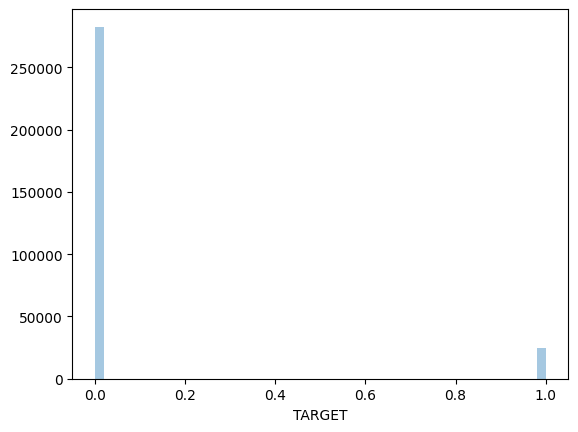

In [11]:
sns.distplot(train_data_for_analysis["TARGET"], kde=False)

<h4>This graph illustrates that 'TARGET' is imbalanced. However we need to use ROC-AUC method, so it is not a problem now</h4>

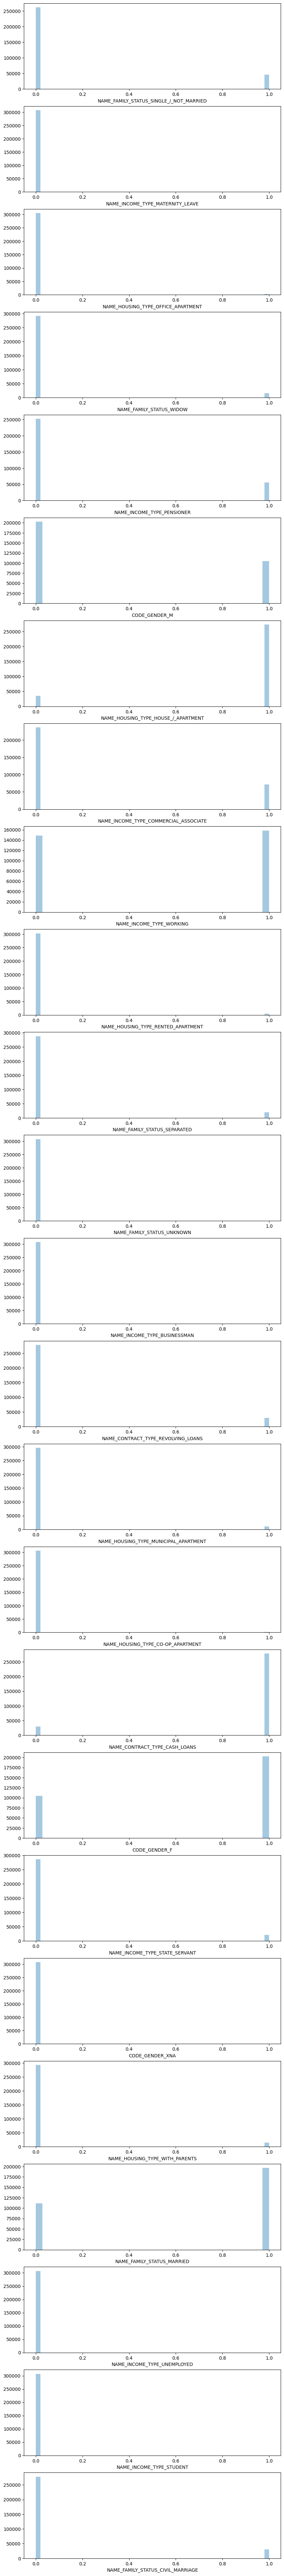

In [12]:
fig, axes = plt.subplots(nrows=len(categorical_features_for_analysi), ncols=1)
fig.set_size_inches(10, 100)
for i, col in enumerate(categorical_features_for_analysi):
    sns.distplot(train_data_for_analysis[col], kde=False, ax=axes[i])
plt.show()

<h4>Some graphs may show imbalances due to the use of the one-hot encoding method for categorical columns</h4>

<h4>In this analysis, a correlation heatmap is generated to visualize the relationships between all features in the dataset. The heatmap highlights the strength of correlations. That can help as to choose which columns we could delete</h4>

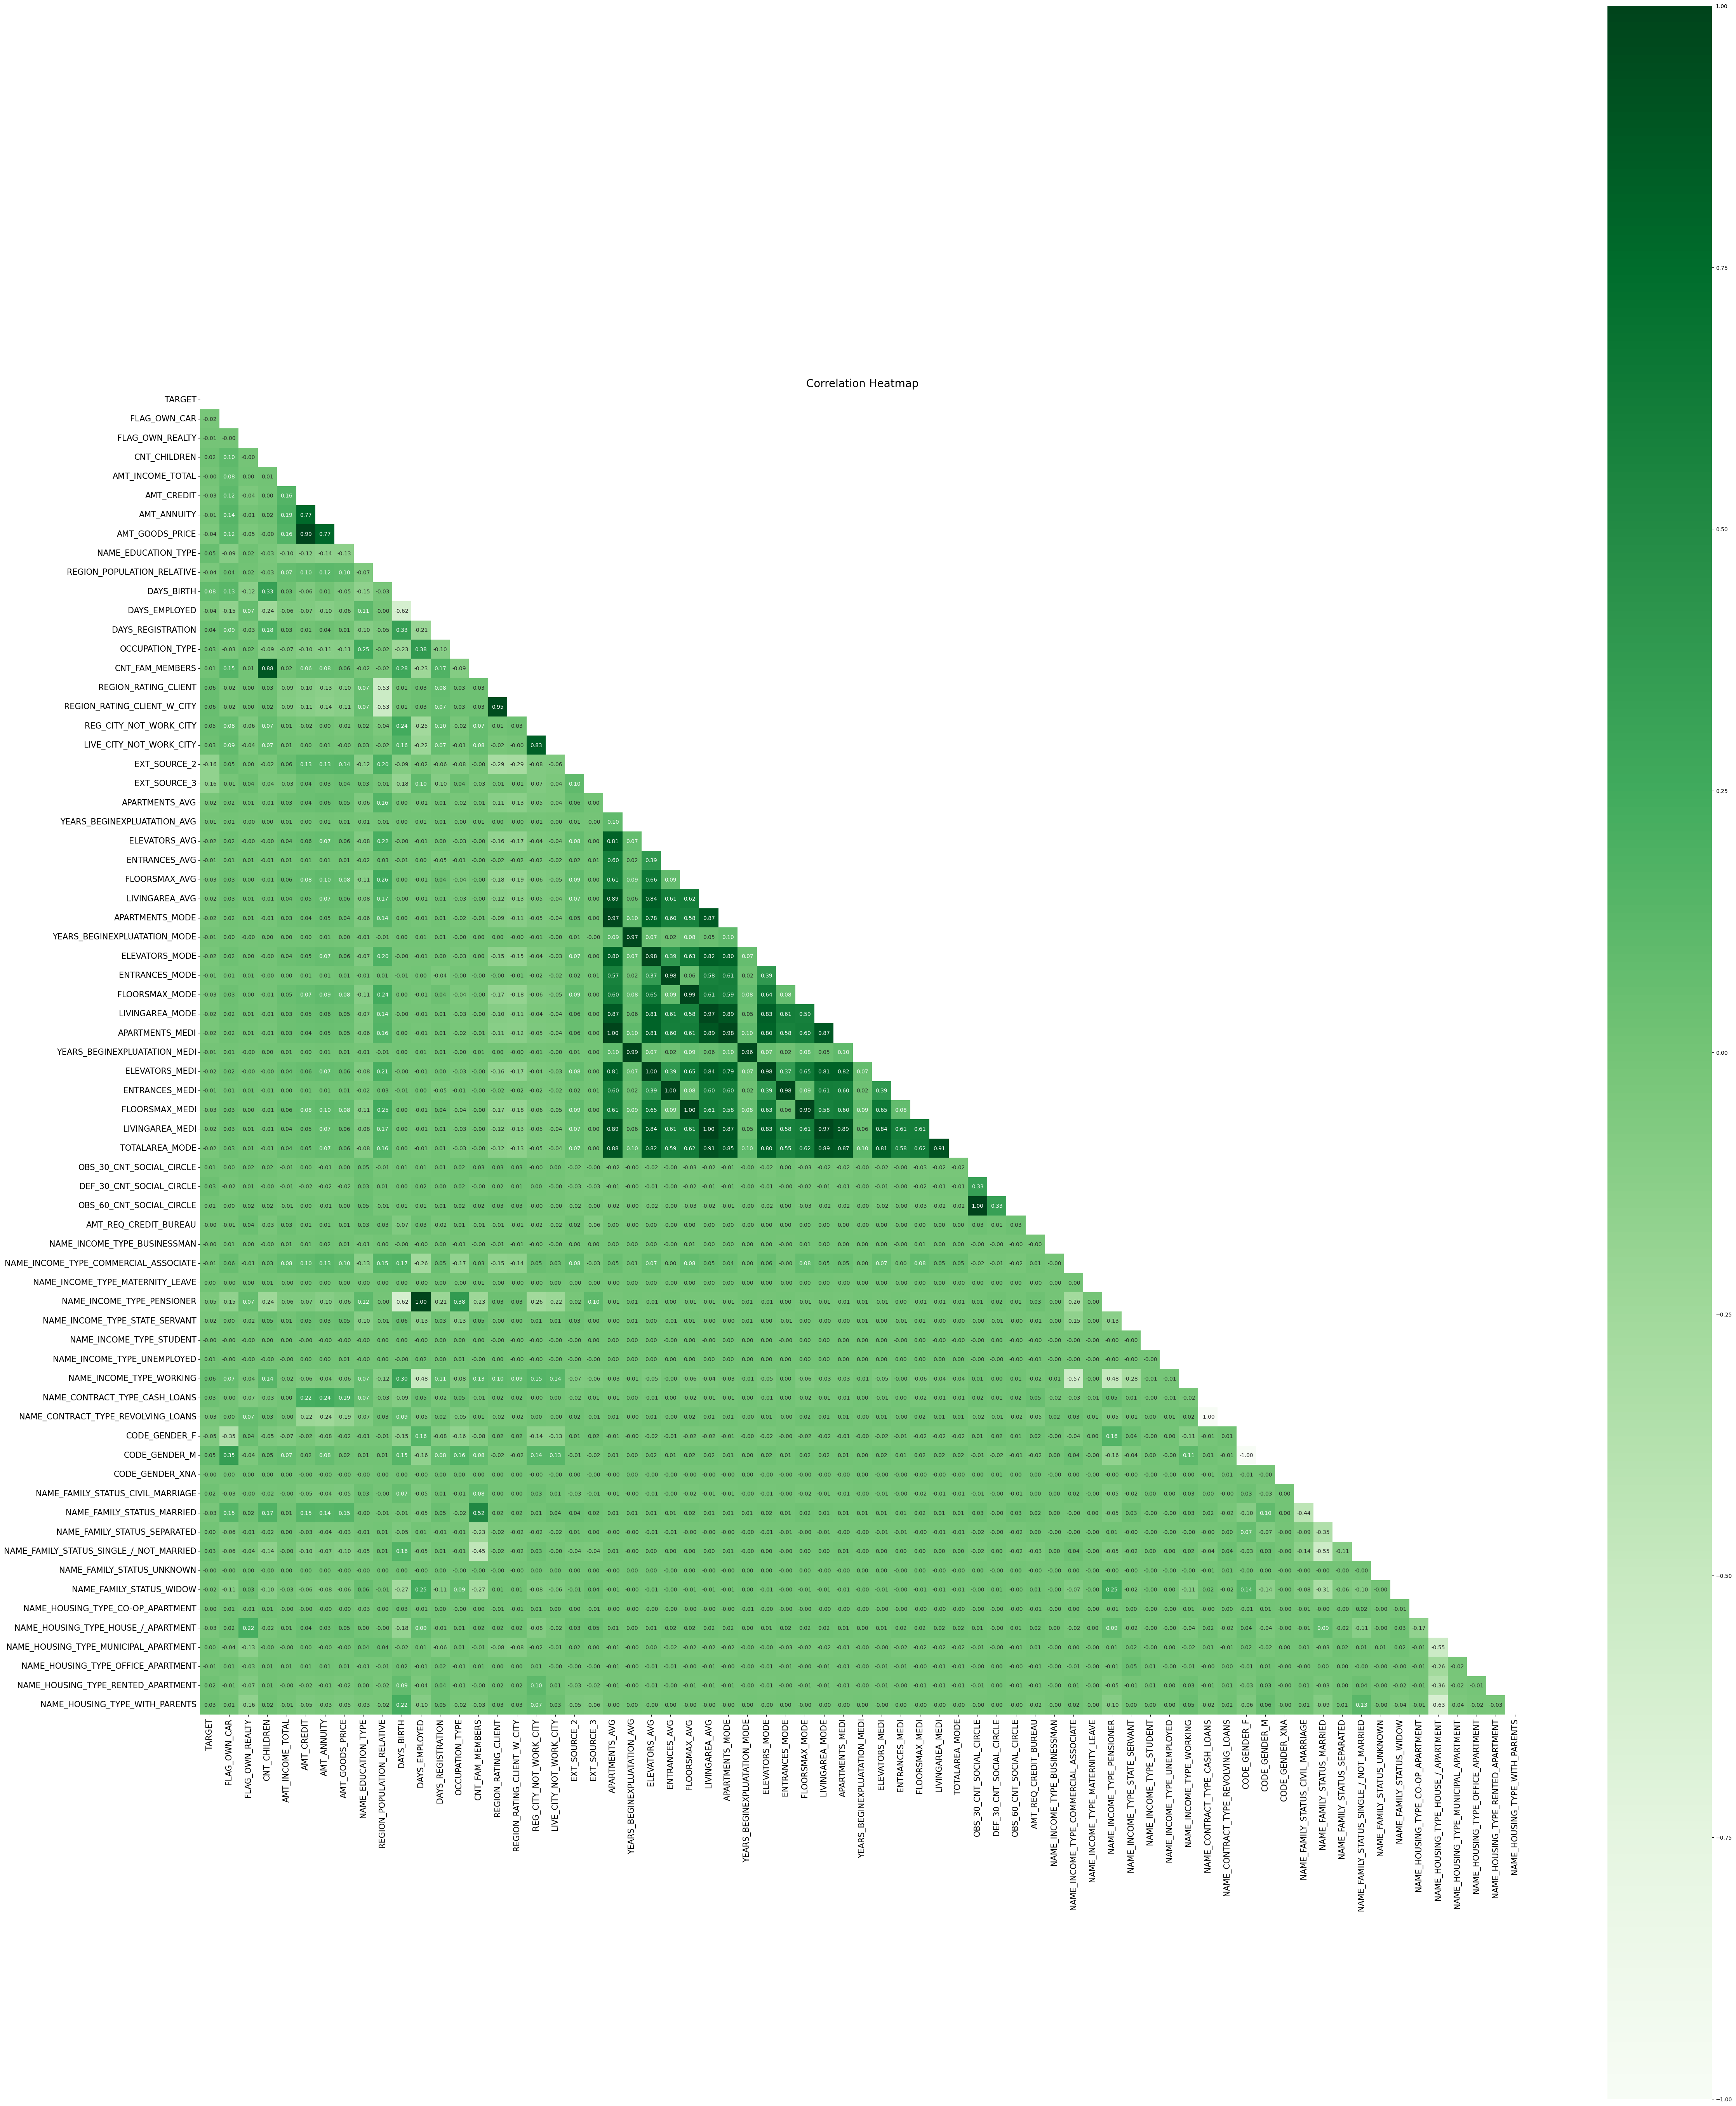

In [13]:
corrMatt = train_data_for_analysis.corr() 

mask = np.triu(np.ones_like(corrMatt, dtype=bool)) 

fig, ax = plt.subplots(figsize=(55, 70)) 
sns.heatmap(corrMatt, cmap="Greens", mask=mask, vmax=1, square=True, annot=True, fmt=".2f", ax=ax)

plt.xticks(fontsize=15)  
plt.yticks(fontsize=15)  
plt.title("Correlation Heatmap", fontsize=20)

plt.show() 

<h4>Chosen data with a high level of correlation to delete</h4>

In [14]:
columnToDelCollisoin=[
'APARTMENTS_MODE',
'YEARS_BEGINEXPLUATATION_MODE',
'ELEVATORS_MODE',
'ENTRANCES_MODE',
'FLOORSMAX_MODE',
'LIVINGAREA_MODE',
'APARTMENTS_MEDI',
'YEARS_BEGINEXPLUATATION_MEDI',
'ELEVATORS_MEDI',
'ENTRANCES_MEDI',
'FLOORSMAX_MEDI',
'LIVINGAREA_MEDI',
'TOTALAREA_MODE',
'OBS_30_CNT_SOCIAL_CIRCLE',
'CNT_CHILDREN'
]

columnToDel.extend(columnToDelCollisoin)



<h4>This analysis uses histograms to visualize the distribution of numerical features, helping to identify patterns, skewness, and potential outliers in the dataset. The plots provide a clear overview of how each numeric variable is distributed.</h4>

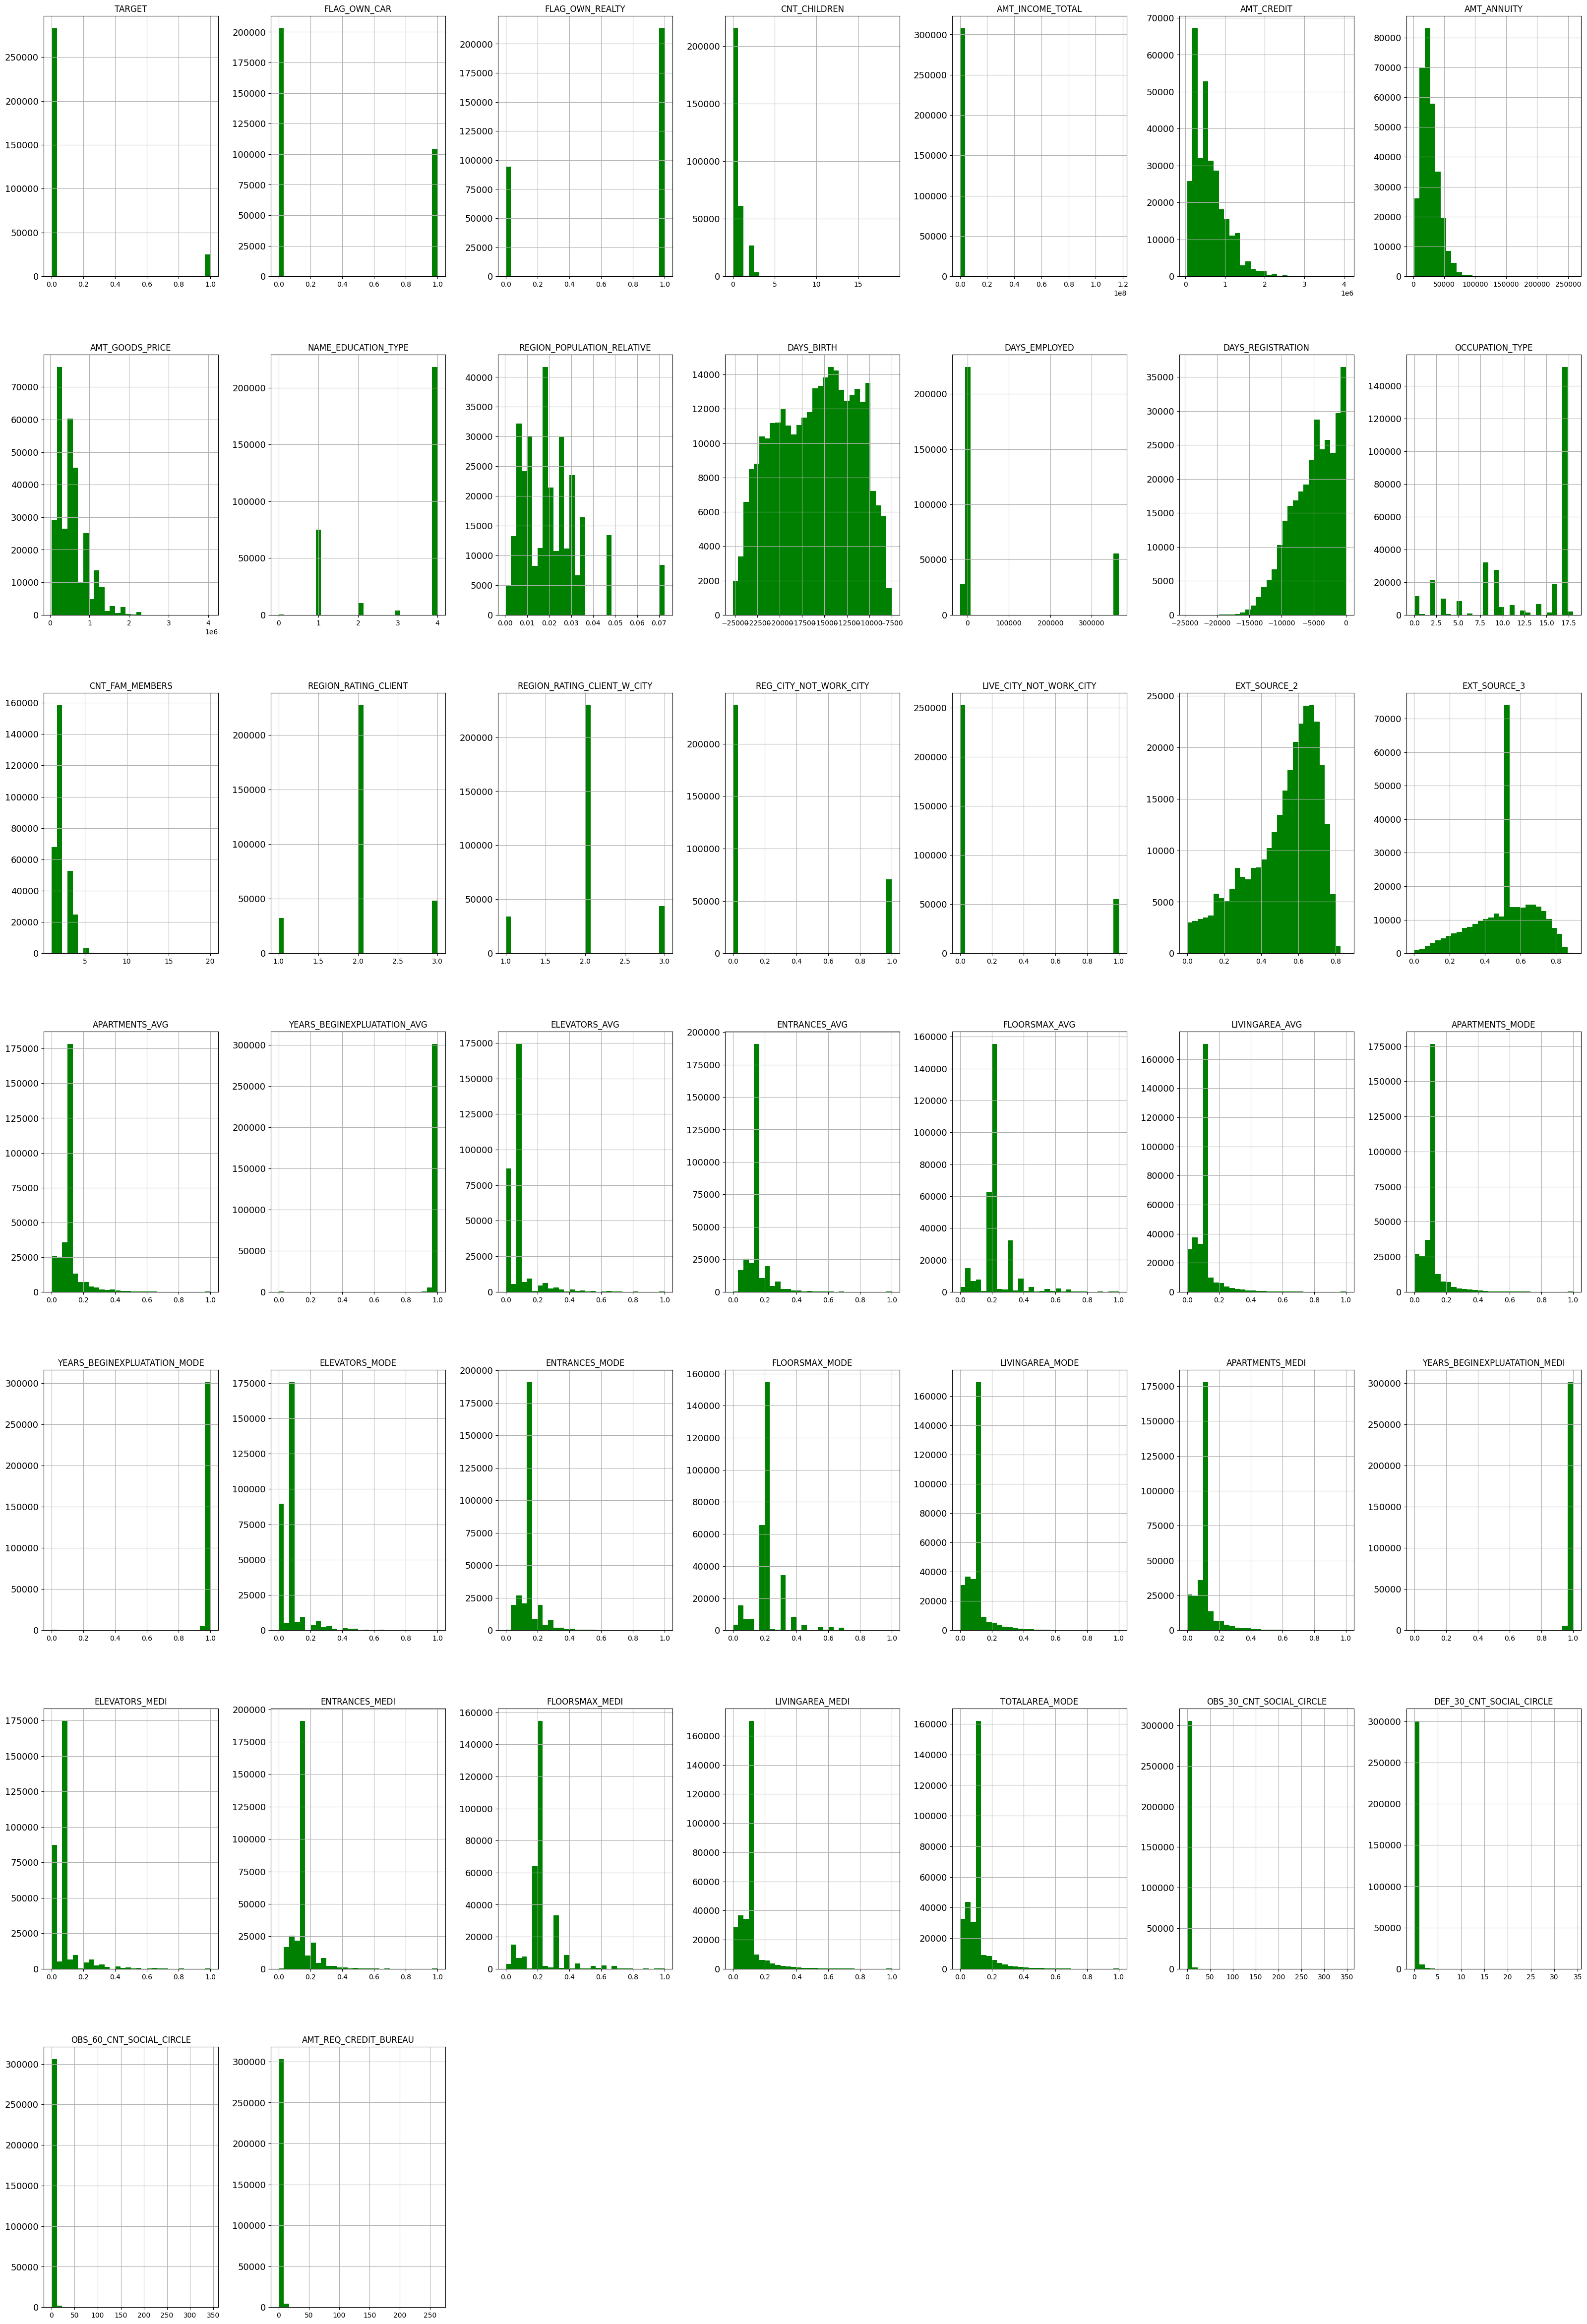

In [15]:
numerical_features = train_data_for_analysis.select_dtypes(include=['float64', 'int64']).columns
train_data_for_analysis[numerical_features].hist(figsize=(40, 60), color = 'g', bins=30, xlabelsize=10, ylabelsize=13)
plt.show() 


<h4>Data preparation</h4>

In [16]:
combain_column('AMT_REQ_CREDIT_BUREAU', columnToCombain, train_data)
del_column(columnToDel, train_data)
clean_data(columnToDel, train_data)
fill_data(train_data)
create_ordinal_features(train_data, ordinal_features, priority)
column_to_categorical(categorical_features, train_data)
normalized_data( train_data)

print(train_data.shape)

(307511, 34)


In [17]:
combain_column('AMT_REQ_CREDIT_BUREAU', columnToCombain, test_data)
del_column(columnToDel, test_data)
clean_data(columnToDel, test_data)
fill_data(test_data)
create_ordinal_features(test_data, ordinal_features, priority)
column_to_categorical(categorical_features, test_data)
normalized_data( test_data)

print(test_data.shape)

(48744, 33)


<h4>This function checks if the train data and the test data have the same column or not and prints the results</h4>

In [18]:
columns_in_train_not_in_test = check_column(train_data, test_data)

Сolumns in train_data, but not in test_data: {'TARGET'}
Column in test_data, but not in train_data: set()
Column in both DataFrames: {'NAME_FAMILY_STATUS', 'CODE_GENDER', 'LIVE_CITY_NOT_WORK_CITY', 'NAME_HOUSING_TYPE', 'ENTRANCES_AVG', 'EXT_SOURCE_3', 'DEF_30_CNT_SOCIAL_CIRCLE', 'OBS_60_CNT_SOCIAL_CIRCLE', 'YEARS_BEGINEXPLUATATION_AVG', 'DAYS_REGISTRATION', 'AMT_REQ_CREDIT_BUREAU', 'REGION_RATING_CLIENT', 'ELEVATORS_AVG', 'LIVINGAREA_AVG', 'REGION_POPULATION_RELATIVE', 'CNT_FAM_MEMBERS', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'DAYS_BIRTH', 'REGION_RATING_CLIENT_W_CITY', 'NAME_CONTRACT_TYPE', 'FLAG_OWN_CAR', 'REG_CITY_NOT_WORK_CITY', 'EXT_SOURCE_2', 'AMT_CREDIT', 'APARTMENTS_AVG', 'AMT_INCOME_TOTAL', 'OCCUPATION_TYPE', 'AMT_GOODS_PRICE', 'AMT_ANNUITY', 'FLAG_OWN_REALTY', 'FLOORSMAX_AVG', 'DAYS_EMPLOYED'}


<h4> Decision tree function creation</h4>

In [19]:
def giniImpurity(data):
    values, counts = np.unique(data, return_counts=True)
    total = len(data)
    return 1 - np.sum((counts / total) ** 2)


def calc_weighted_average(data, feature, target):

        if data[feature].dtypes in ['int64', 'float64']:

            feature_values = sorted(data[feature].unique())
            best_weighted_average = np.inf
            best_split_value = None

            sorted_data = data.sort_values(by=feature)
            left_target = sorted_data[target].iloc[:1]  
            right_target = sorted_data[target].iloc[1:] 
            
            for i, value in enumerate(feature_values):
                left_target = sorted_data[target].iloc[:i]
                right_target = sorted_data[target].iloc[i:]

                length = len(data)
                weighted_average = (len(left_target) / length) * giniImpurity(left_target) + (len(right_target) / length) * giniImpurity(right_target)

                if weighted_average < best_weighted_average:
                    best_weighted_average = weighted_average
                    best_split_value = value

            return best_weighted_average , best_split_value

        else:
            feature_values = data[feature].value_counts()
            weighted_average = 0

            for value in feature_values.index:
                subset_target = data.loc[data[feature] == value, target]
                length = len(data)
                if length > 0:  
                    weighted_average += (len(subset_target) / length) * giniImpurity(subset_target)
        
        return  weighted_average, None


def best_split(data, target):
    best_feature = None
    best_weighted_average = np.inf
    best_split_value = None
    
    features = list(data.columns) 
    features.remove(target)  


    for feature in features:
            weighted_average, split_value = calc_weighted_average(data, feature, target)
            if weighted_average < best_weighted_average:
                best_weighted_average = weighted_average
                best_feature = feature
                best_split_value = split_value
            
            if best_weighted_average == 0:
                break
    
    return best_feature, best_split_value


def build_tree(data, target, max_depth, current_depth):

    if len(data[target].unique()) == 1 or current_depth >= max_depth:
        return data[target].mean()
    
    if len(data.columns) == 1:
        return data[target].mean()
    
    
    best_feature, best_split_value = best_split(data, target)  

    if best_feature is None:
         return data[target].mean()
    
    tree = {best_feature: {}}

    if best_split_value is not None:
            left = data[data[best_feature] <= best_split_value]
            right = data[data[best_feature] > best_split_value]

            if not left.empty:
                tree[best_feature]["<=" + str(float(best_split_value))] = build_tree(left.drop(columns=[best_feature]), target, max_depth, current_depth + 1)
            else:
               tree[best_feature]["<=" + str(float(best_split_value))] = data[target].mean()

            if not right.empty:
                tree[best_feature][">" + str(float(best_split_value))] = build_tree(right.drop(columns=[best_feature]), target, max_depth, current_depth + 1) 
            else:
               tree[best_feature][">" + str(float(best_split_value))] = data[target].mean()
        
    else:
            feature_values = data[best_feature].unique()
            for value in feature_values:
                subset = data[data[best_feature] == value]
                if not subset.empty:
                    tree[best_feature][value] = build_tree(subset.drop(columns=[best_feature]), target, max_depth, current_depth + 1)
                else:
                    tree[best_feature][value] = data[target].mean()

        
    return tree


<h4> Prediction function for decision tree</h4>

In [20]:
def predict(tree, row, test_data):

    if isinstance(tree, (str, int, float, np.number)):
        return tree

    node_value = list(tree.keys())[0]
    data_value = row[node_value]

    if test_data[node_value].dtypes in ['int64', 'float64']:
        possible_node_keys = list(tree[node_value].keys())

        key = None
        for key in possible_node_keys:
            if "<=" in str(key):
                key = float(key.split("<=")[1])
                break

        if key is not None:
            if data_value <= key:
                if "<=" + str(key) in tree[node_value]:
                    return predict(tree[node_value]["<=" + str(key)], row, test_data)
            else:
                if ">" + str(key) in tree[node_value]:
                    return predict(tree[node_value][">" + str(key)], row, test_data)

        else:
            print(f"Missing split value in tree for feature: {node_value}")
            return '0.0'

    elif data_value in tree[node_value]:
        return predict(tree[node_value][data_value], row, test_data)

    else:
        print(f"Missing key {data_value} in node {node_value}")
        return '0.0'


<h4>The function calculates the True Positive Rate (TPR) and False Positive Rate (FPR) across some threshold values, then computes the Area Under the Curve (AUC) for the ROC curve</h4>

In [21]:
def calculate_fpr_tpr(y_true, y_predict):

    thresholds = np.arange(-1, 1, 0.01)[::-1]


    tpr_list = []
    fpr_list = []
        
    for threshold in thresholds:
        predicted_labels = (y_predict >= threshold).astype(int)
        tp = np.sum((predicted_labels == 1) & (y_true == 1))
        fp = np.sum((predicted_labels == 1) & (y_true == 0))
        tn = np.sum((predicted_labels == 0) & (y_true == 0))
        fn = np.sum((predicted_labels == 0) & (y_true == 1))
        
        tpr = tp / (tp + fn) if (tp + fn) > 0 else 0
        fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
        
        tpr_list.append(tpr)
        fpr_list.append(fpr)
    
    return fpr_list, tpr_list, thresholds

def calculate_auc(fpr, tpr):
    auc = 0.0
    for i in range(1, len(fpr)):
        auc += (fpr[i] - fpr[i-1]) * (tpr[i] + tpr[i-1]) / 2
    return auc


<h4> Following this, the data was separated into a decision tree data set and a linear regression data set. Once it has been done, the linear regression data set is computed with the one-hot method as the library required</h4>

In [22]:
train_data_decision_tree = train_data.copy()
train_data_linear_regression = train_data.copy()

In [23]:
train_data_linear_regression, categorical_features= one_hot_encoding(train_data_linear_regression, nominal_features, categorical_features)
print(train_data_linear_regression.shape)

(307511, 54)


In [24]:
target = 'TARGET'
train_data_decision_tree_train = train_data_decision_tree.head(200000)

train_data_decision_tree_test_sample = train_data_decision_tree.tail(len(train_data) - 200000)
train_data_decision_tree_test_target = train_data_decision_tree_test_sample['TARGET']
train_data_decision_tree_test_sample = train_data_decision_tree_test_sample.drop('TARGET', axis=1)

In [25]:
train_data_linear_regression_train_sample = train_data_linear_regression.head(200000)
train_data_linear_regression_train_target = train_data_linear_regression_train_sample['TARGET']
train_data_linear_regression_train_sample = train_data_linear_regression_train_sample.drop('TARGET', axis=1)

train_data_linear_regression_test_sample = train_data_linear_regression.tail(len(train_data) - 200000)
train_data_linear_regression_test_target = train_data_linear_regression_test_sample['TARGET']
train_data_linear_regression_test_sample = train_data_linear_regression_test_sample.drop('TARGET', axis=1)

<h4> The next step is the creation of the tree, which was taught by our train data set<h4>

In [26]:
decision_tree = build_tree(train_data_decision_tree_train, target, 9, 0)
import pprint
pprint.pprint(decision_tree)

{'EXT_SOURCE_2': {'<=0.5450498319755075': {'DAYS_BIRTH': {'<=0.9543968432919955': {'NAME_INCOME_TYPE': {'Commercial associate': {'EXT_SOURCE_3': {'<=0.934937075400463': {'DAYS_EMPLOYED': {'<=0.0454750688363717': {'CODE_GENDER': {'F': {'ELEVATORS_AVG': {'<=0.0288': {'NAME_HOUSING_TYPE': {'Co-op apartment': {'ENTRANCES_AVG': {'<=0.069': np.float64(0.5),
                                                                                                                                                                                                                                                                                                                                      '>0.069': np.float64(0.0)}},
                                                                                                                                                                                                                                                                                                'Ho

<h4> Also create model for linear regression </h4>

In [27]:
reg = LinearRegression()
reg.fit(train_data_linear_regression_train_sample, train_data_linear_regression_train_target) 

print("Model coefficients:", reg.coef_)  
print("Intercept:", reg.intercept_) 

Model coefficients: [-2.05666267e-02  2.80376912e-03  5.34651073e-01  5.92870696e-01
  2.04669087e-01 -7.39028032e-01  3.04911546e-02  8.02595075e-03
  2.47662557e-02  7.21691153e-01  1.40437617e-02  1.12424188e-02
  1.38388780e-02 -2.20535948e-02  4.40239304e-02  1.26630472e-02
 -8.34848426e-03 -1.54366026e-01 -1.85978598e-01  7.44390327e-03
 -3.28636508e-02 -3.70870965e-04 -2.99144343e-02 -3.55691910e-02
  1.47322987e-02  5.17674062e-01 -1.08959037e-01 -2.88944261e-01
  2.80606968e+10  2.80606968e+10  2.80606968e+10  2.80606968e+10
  2.80606968e+10  2.80606968e+10  2.80606968e+10  2.80606968e+10
  3.74612944e+11  3.74612944e+11  1.68364297e+11  1.68364297e+11
  1.68364297e+11 -3.83696772e+11 -3.83696772e+11 -3.83696772e+11
 -3.83696772e+11 -3.83696772e+11 -3.83696772e+11  6.93827861e+10
  6.93827861e+10  6.93827861e+10  6.93827861e+10  6.93827861e+10
  6.93827861e+10]
Intercept: -256723950962.5204


<h4> Then prediction functions are used for both methods and results are saved in two arreys</h4>

In [28]:
predictions_decision_tree = []
data_example = train_data_decision_tree_test_sample.head(2)
for row in train_data_decision_tree_test_sample.itertuples(index=False, name='Row'):
    row_series = pd.Series(row, index=train_data_decision_tree_test_sample.columns)  
    predictions_decision_tree.append(predict(decision_tree, row_series, data_example))

print(len(predictions_decision_tree))

Missing key Civil marriage in node NAME_FAMILY_STATUS
Missing key Municipal apartment in node NAME_HOUSING_TYPE
Missing key Maternity leave in node NAME_INCOME_TYPE
Missing key Single / not married in node NAME_FAMILY_STATUS
Missing key Municipal apartment in node NAME_HOUSING_TYPE
Missing key Separated in node NAME_FAMILY_STATUS
Missing key Single / not married in node NAME_FAMILY_STATUS
Missing key Co-op apartment in node NAME_HOUSING_TYPE
Missing key With parents in node NAME_HOUSING_TYPE
Missing key Maternity leave in node NAME_INCOME_TYPE
Missing key Civil marriage in node NAME_FAMILY_STATUS
107511


In [29]:
predictions_linear_regression = reg.predict(train_data_linear_regression_test_sample)

<h4> At this point, both predictions are computed by ROC_AUC metrics and graph, which display results are built</h4>

In [30]:
predictions_decision_tree = np.array(predictions_decision_tree , dtype=float)
train_data_decision_tree_test_target = np.array(train_data_decision_tree_test_target , dtype=float)

fpr_decision_tree, tpr_decision_tree, thresholds_decision_tree = calculate_fpr_tpr(train_data_decision_tree_test_target, predictions_decision_tree)

roc_auc_decision_tree = calculate_auc(fpr_decision_tree, tpr_decision_tree)

print(f"AUC = {roc_auc_decision_tree:.4f}")

AUC = 0.6547


In [31]:
predictions_linear_regression = np.array(predictions_linear_regression, dtype=float)
train_data_linear_regression_test_target = np.array(train_data_linear_regression_test_target, dtype=float)

fpr_linear_regression, tpr_linear_regression, thresholds_decision_tree = calculate_fpr_tpr(train_data_linear_regression_test_target, predictions_linear_regression)

roc_auc_linear_regression = calculate_auc(fpr_linear_regression, tpr_linear_regression)

print(f"AUC = {roc_auc_linear_regression:.4f}")

AUC = 0.7403


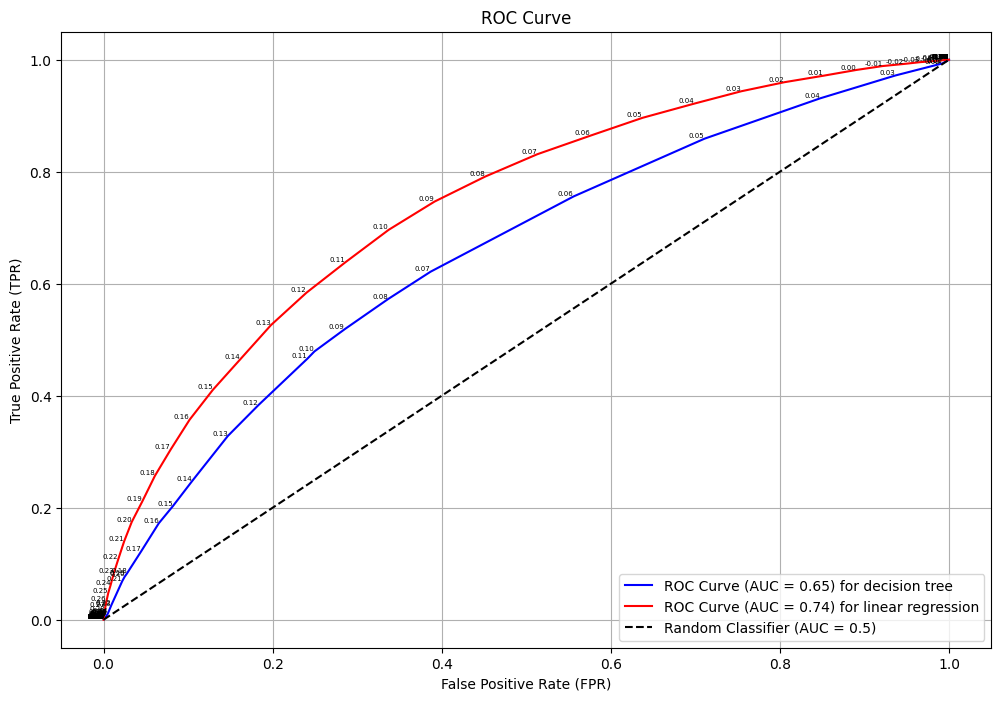

In [32]:

plt.figure(figsize=(12, 8))
plt.plot(fpr_decision_tree, tpr_decision_tree, label=f'ROC Curve (AUC = {roc_auc_decision_tree:.2f}) for decision tree', color='b')
plt.plot(fpr_linear_regression, tpr_linear_regression, label=f'ROC Curve (AUC = {roc_auc_linear_regression:.2f}) for linear regression', color='r')
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier (AUC = 0.5)')


for i in range(len(thresholds_decision_tree)):
    plt.text(fpr_decision_tree[i], tpr_decision_tree[i], f'{thresholds_decision_tree[i]:.2f}', fontsize=5, ha='right', va='bottom')

for i in range(len(thresholds_decision_tree)):
    plt.text(fpr_linear_regression[i], tpr_linear_regression[i], f'{thresholds_decision_tree[i]:.2f}', fontsize=5, ha='right', va='bottom')

plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

<h4> Last but not the least step is to process train data set using our tree and write results into a csv file</h4>

In [33]:
final_predictions = []
data_example = test_data.head(2)
for row in test_data.itertuples(index=False, name='Row'):
    row_series = pd.Series(row, index=test_data.columns)  
    final_predictions.append(predict(decision_tree, row_series, data_example))

print(len(final_predictions))
final_predictions = np.array(final_predictions, dtype=float)

final_predictions = (final_predictions >= 0.07).astype(int)

count_ones = np.sum(final_predictions == 1)
count_zeros = np.sum(final_predictions == 0)

print(f"1 count: {count_ones}")
print(f"0 count: {count_zeros}")

Missing key Office apartment in node NAME_HOUSING_TYPE
Missing key With parents in node NAME_HOUSING_TYPE
Missing key With parents in node NAME_HOUSING_TYPE
Missing key Separated in node NAME_FAMILY_STATUS
Missing key Widow in node NAME_FAMILY_STATUS
48744
1 count: 22859
0 count: 25885


In [34]:
predictions_df = pd.DataFrame({
    'SK_ID_CURR': id_test,
    'TARGET': final_predictions
})

predictions_df.to_csv('final_predictions.csv', index=False)

